## Word2Vec sequence embeddings into  Deep Learning models

Use w2v embeddings learned across train + test comments in Convolutional and Recurrent networks

In [2]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv1D, Embedding, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate
from keras.layers import Bidirectional,LSTM
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
pd.set_option('max_colwidth',140)

### Read in training data

In [7]:
full_train = pd.read_csv('../train.csv')
full_train.shape

(95851, 8)

In [8]:
labels = np.array(full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']])

In [9]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [10]:
comments=full_train['comment_text'].tolist()

In [11]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

### Read in test data

In [12]:
testdat = pd.read_csv('../test.csv')

In [13]:
test_comments0 = testdat['comment_text'].tolist()

In [14]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1        

52300 nan


In [15]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

In [16]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()

In [20]:
reduced_token_count = token_count[token_count['freq']>=15]
reduced_token_count.shape
reduced_token_set = set(reduced_token_count['token'])

In [21]:
reduced_token_count.sample(5)

,index,token,freq
20707,20707,characterisation,28
18356,18356,frankish,34
6682,6682,backwards,167
27326,27326,newspaper's,18
30826,30826,indenting,15


#### Convert training sequences to index

In [22]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token).to_dict()

In [20]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [21]:
print(tokenized_comments[0])
print(tokenized_corpus[0])

['nonsense', 'kiss', 'off', 'geek', 'what', 'i', 'said', 'is', 'true', "i'll", 'have', 'your', 'account', 'terminated']
[853, 2316, 340, 9168, 53, 9, 216, 8, 396, 326, 22, 24, 218, 13547]


In [22]:
comment_length = []
for comment in tokenized_comments:
    comment_length.append(len(comment))
comment_length = np.array(comment_length)
np.percentile(comment_length,80)

90.0

In [133]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [144]:
np.mean(comment_length[clean_comment==0]<80)

0.85342185903983658

(0, 600)

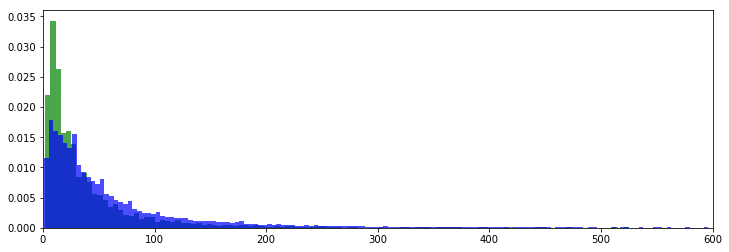

In [135]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(comment_length[clean_comment==0], 300, normed=1, facecolor='green', alpha=0.7)
n, bins, patches = plt.hist(comment_length[clean_comment==1], 300, normed=1, facecolor='blue', alpha=0.7)
plt.xlim([0,600])

In [145]:
MAX_SEQ_LENGTH=80
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

### Load w2v model

In [29]:
w2v_model = gensim.models.Word2Vec.load("../wiki_comment_word2vec")

In [30]:
len(w2v_model.wv.vocab)

31293

In [31]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=50
print((V,EMBEDDING_DIM))

(31294, 50)


In [32]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = w2v_model.wv[token]

In [33]:
embed_matrix.shape

(31294, 50)

### Split training data into train,valid sets

In [146]:
labels0,tokenized_corpus_padded0 = shuffle(labels,tokenized_corpus_padded)

In [147]:
labels_train,labels_valid, \
seq_train,seq_valid  = \
train_test_split(labels0,tokenized_corpus_padded0,\
                 test_size=0.2,stratify=clean_comment)

In [148]:
print(np.mean(labels_train,axis=0))
print(labels_train.shape)
print(np.mean(labels_valid,axis=0))
print(labels_valid.shape)

[ 0.09685707  0.01005477  0.05329943  0.00323422  0.04988263  0.00864632]
(76680, 6)
[ 0.09441344  0.01011945  0.05330969  0.00297324  0.04903239  0.00787648]
(19171, 6)


### Lightweight convolutional model

In [ ]:
# (with 300 length sequences)

In [126]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=300
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [55]:
# Convolutional layers: width 7
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(embed_seq_unmasked)
Conv7_layer = MaxPooling1D(2)(Conv7_layer)
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(Conv7_layer)
Conv7_layer = GlobalMaxPool1D()(Conv7_layer)
Conv7_layer = Dropout(0.5)(Conv7_layer)

In [58]:
#Conv_dense = Dense(50,activation='relu')(Conv_cat)
Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(Conv7_layer)
Conv_output = Dense(6, activation="sigmoid")(Conv_dense)

In [59]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 300)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 300, 50)           1564700   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 300, 64)           22464     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 150, 64)           28736     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [60]:
history_CNN = cnn_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 246s - loss: 0.0779 - acc: 0.9753 - val_loss: 0.0574 - val_acc: 0.9802
Epoch 2/6
76680/76680 [==============================] - 246s - loss: 0.0595 - acc: 0.9795 - val_loss: 0.0562 - val_acc: 0.9804
Epoch 3/6
76680/76680 [==============================] - 246s - loss: 0.0558 - acc: 0.9804 - val_loss: 0.0544 - val_acc: 0.9803
Epoch 4/6
76680/76680 [==============================] - 247s - loss: 0.0540 - acc: 0.9808 - val_loss: 0.0552 - val_acc: 0.9801
Epoch 5/6
76680/76680 [==============================] - 248s - loss: 0.0523 - acc: 0.9812 - val_loss: 0.0548 - val_acc: 0.9804
Epoch 6/6
76680/76680 [==============================] - 243s - loss: 0.0509 - acc: 0.9816 - val_loss: 0.0557 - val_acc: 0.9807


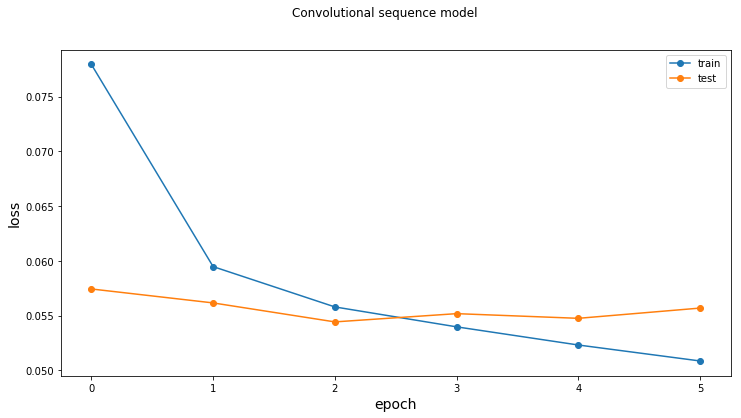

In [101]:
plt.figure(figsize=(12,6))
plt.suptitle("Convolutional sequence model")
#plt.subplot(121)
plt.plot(history_CNN.history['loss'],'-o',label='train')
plt.plot(history_CNN.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)
#plt.subplot(122)
#plt.plot(history_CNN.history['acc'],label='train')
#plt.plot(history_CNN.history['val_acc'],label='test')
#plt.legend()
#plt.xlabel('epoch',fontsize=14)
#plt.xlabel('accuracy',fontsize=14)

In [27]:
np.min(history_CNN.history['val_loss'])

NameError: name 'history_CNN' is not defined

### Recurrent model

In [160]:
# Sequence input
sequence_input = Input(shape=(80,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=80
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [161]:
recurrent_layer = Bidirectional(LSTM(30, return_sequences=True))(embed_seq_unmasked) #dropout=0.1, recurrent_dropout=0.1
recurrent_layer = GlobalMaxPool1D()(recurrent_layer)
recurrent_layer = Dropout(0.5)(recurrent_layer)

In [162]:
recurrent_dense = Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(recurrent_layer)
recurrent_output = Dense(6, activation="sigmoid")(recurrent_dense)

In [163]:
lstm_model = Model(inputs=sequence_input, output=recurrent_output)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 80)                0         
_________________________________________________________________
Embedding (Embedding)        (None, 80, 50)            1564700   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 80, 60)            19440     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 60)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                976       
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 102       
Total para

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [164]:
history_LSTM = lstm_model.fit(seq_train,labels_train
                           ,epochs=3
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/3
76680/76680 [==============================] - 1107s - loss: 0.0763 - acc: 0.9758 - val_loss: 0.0556 - val_acc: 0.9811
Epoch 2/3
76680/76680 [==============================] - 1109s - loss: 0.0598 - acc: 0.9793 - val_loss: 0.0544 - val_acc: 0.9808
Epoch 3/3
76680/76680 [==============================] - 1111s - loss: 0.0571 - acc: 0.9800 - val_loss: 0.0525 - val_acc: 0.9815


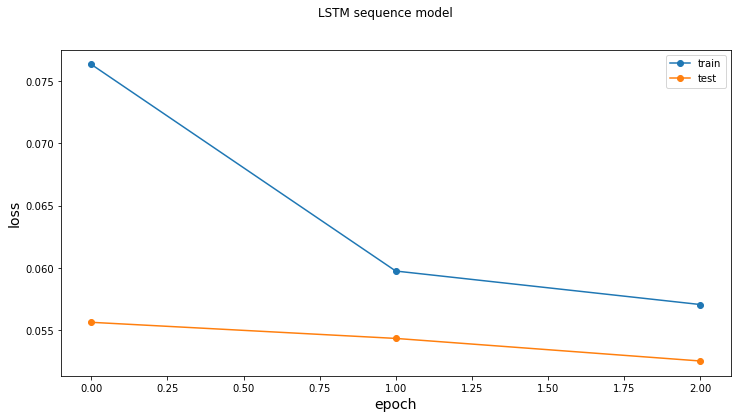

In [165]:
plt.figure(figsize=(12,6))
plt.suptitle("LSTM sequence model")
plt.plot(history_LSTM.history['loss'],'-o',label='train')
plt.plot(history_LSTM.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

### Wider w2v inputs (150d)

In [175]:
wide_w2v_model = gensim.models.Word2Vec.load("../wiki_comment_word2vec_150d")

In [178]:
V = len(reduced_token_set)+1
EMBEDDING_DIM_WIDE=150
print((V,EMBEDDING_DIM_WIDE))

(31294, 150)


In [181]:
wide_embed_matrix = np.zeros((V,EMBEDDING_DIM_WIDE))
for token in token_index_dict.keys():
    wide_embed_matrix[token_index_dict[token]] = wide_w2v_model.wv[token]
                             
wide_embed_matrix.shape

(31294, 150)

### ConvNet with wider w2v

In [182]:
# Sequence input
sequence_input = Input(shape=(80,),dtype='int32',name='Input')

# Embedding lookup
wider_embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM_WIDE
                              ,weights=[wide_embed_matrix]
                              ,input_length=80
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [183]:
# Convolutional layers: width 7
wide_Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(wider_embed_seq_unmasked)
wide_Conv7_layer = MaxPooling1D(2)(wide_Conv7_layer)
wide_Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(wide_Conv7_layer)
wide_Conv7_layer = GlobalMaxPool1D()(wide_Conv7_layer)
wide_Conv7_layer = Dropout(0.5)(wide_Conv7_layer)

In [184]:
#Conv_dense = Dense(50,activation='relu')(Conv_cat)
wide_Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(wide_Conv7_layer)
wide_Conv_output = Dense(6, activation="sigmoid")(wide_Conv_dense)

In [185]:
wide_cnn_model = Model(inputs=sequence_input, outputs=wide_Conv_output)
wide_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
wide_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 80)                0         
_________________________________________________________________
Embedding (Embedding)        (None, 80, 150)           4694100   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 80, 64)            67264     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 40, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 40, 64)            28736     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 64)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
__________

In [186]:
history_wider_CNN = wide_cnn_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 144s - loss: 0.0756 - acc: 0.9762 - val_loss: 0.0551 - val_acc: 0.9810
Epoch 2/6
76680/76680 [==============================] - 154s - loss: 0.0575 - acc: 0.9801 - val_loss: 0.0555 - val_acc: 0.9796
Epoch 3/6
76680/76680 [==============================] - 141s - loss: 0.0538 - acc: 0.9810 - val_loss: 0.0528 - val_acc: 0.9810
Epoch 4/6
76680/76680 [==============================] - 141s - loss: 0.0505 - acc: 0.9819 - val_loss: 0.0540 - val_acc: 0.9808
Epoch 5/6
76680/76680 [==============================] - 141s - loss: 0.0474 - acc: 0.9828 - val_loss: 0.0534 - val_acc: 0.9813
Epoch 6/6
76680/76680 [==============================] - 142s - loss: 0.0446 - acc: 0.9836 - val_loss: 0.0543 - val_acc: 0.9811


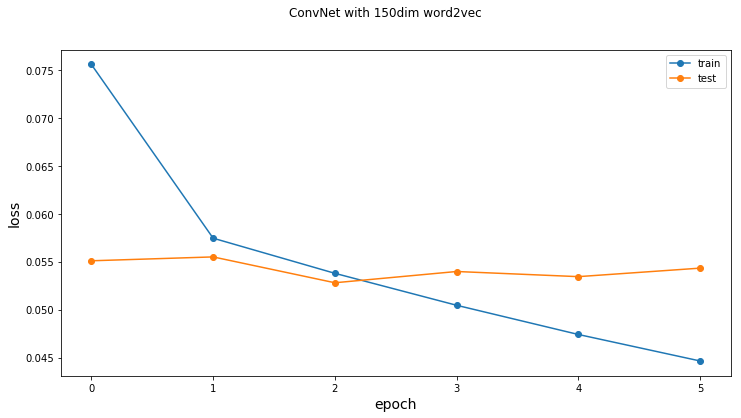

In [187]:
plt.figure(figsize=(12,6))
plt.suptitle("ConvNet with 150dim word2vec")
plt.plot(history_wider_CNN.history['loss'],'-o',label='train')
plt.plot(history_wider_CNN.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

In [191]:
wider_recurrent_layer = Bidirectional(LSTM(30, return_sequences=True))(wider_embed_seq_unmasked) #dropout=0.1, recurrent_dropout=0.1
wider_recurrent_layer = GlobalMaxPool1D()(wider_recurrent_layer)
wider_recurrent_layer = Dropout(0.5)(wider_recurrent_layer)

In [192]:
wider_recurrent_dense = Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(wider_recurrent_layer)
wider_recurrent_output = Dense(6, activation="sigmoid")(wider_recurrent_dense)

In [193]:
wider_lstm_model = Model(inputs=sequence_input, output=wider_recurrent_output)
wider_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
wider_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 80)                0         
_________________________________________________________________
Embedding (Embedding)        (None, 80, 150)           4694100   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 60)            43440     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 60)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                976       
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 102       
Total para

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [194]:
history_wider_LSTM = wider_lstm_model.fit(seq_train,labels_train
                           ,epochs=3
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/3
76680/76680 [==============================] - 1143s - loss: 0.0748 - acc: 0.9758 - val_loss: 0.0531 - val_acc: 0.9815
Epoch 2/3
76680/76680 [==============================] - 1139s - loss: 0.0568 - acc: 0.9803 - val_loss: 0.0512 - val_acc: 0.9820
Epoch 3/3
76680/76680 [==============================] - 1127s - loss: 0.0534 - acc: 0.9811 - val_loss: 0.0508 - val_acc: 0.9817


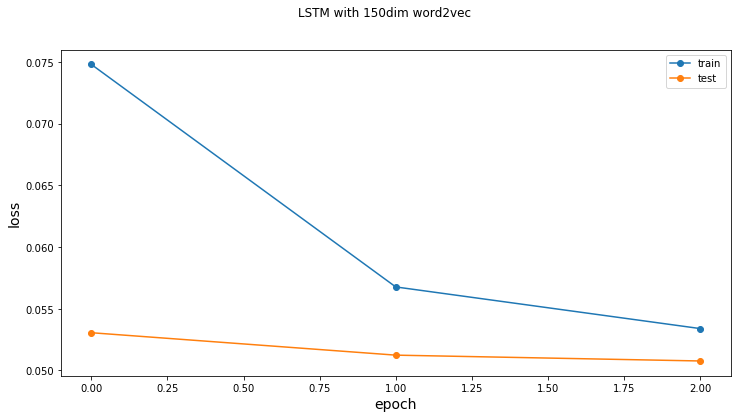

In [195]:
plt.figure(figsize=(12,6))
plt.suptitle("LSTM with 150dim word2vec")
plt.plot(history_wider_LSTM.history['loss'],'-o',label='train')
plt.plot(history_wider_LSTM.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

#### Kaggle test set scoring

In [168]:
tokenized_test = []
for line in test_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_test += [line_token_idx]

In [169]:
tokenized_test_padded = pad_sequences(tokenized_test,maxlen=80)

In [238]:
lstm_kaggle_predict = wider_lstm_model.predict(tokenized_test_padded)

In [239]:
kaggle_submit = pd.DataFrame(lstm_kaggle_predict)
print(kaggle_submit.shape)
kaggle_submit.columns = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

(226998, 6)


In [240]:
kaggle_submit['id'] = testdat['id']
kaggle_submit = kaggle_submit[['id','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
kaggle_submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.004043,0.000018,0.001204,0.000116,0.000567,0.000200
1,6102620,0.002528,0.000003,0.000604,0.000019,0.000350,0.000074
2,14563293,0.001390,0.000001,0.000359,0.000012,0.000159,0.000035
3,21086297,0.002894,0.000006,0.000669,0.000048,0.000399,0.000108
4,22982444,0.003443,0.000011,0.000898,0.000080,0.000487,0.000159


In [241]:
kaggle_submit.to_csv("../150w2v_lstm_3e_submit.csv",index=False)

Kaggle leaderboard score = 0.052 (#840 at the time of submission)

In [251]:
testdat[testdat['id'].isin(kaggle_submit[kaggle_submit['identity_hate']>0.2].sample(10)['id'])]

,id,comment_text
6297,27490178016,Block me then you cocksucker - clever people don't give a fuck about editing Wikikpedia? Just because Wikipedia has turned you into its ...
10064,44177310624,"All I Have to say to you, is go fuck yourself. You're a cocksucker with a little power that's massively gone to your head"
12096,53183071356,ARSE YOU FUCKING PRICK. FUCK OFF.
17253,75859090464,"no fucking shit, dick head."
48415,214088056645,About fucking time you retarded little bitch!
100306,442485882227,aka cock sucking lover of VegaDick
116253,512743720186,You twats know fuck all about anything.
176353,777370561067,hey Jingiby you hate Turkic people because you are a racist Slavic Bulgarian... but you hate your Turkic ancestries... everybody hate yo...
193494,852936198507,WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER WANKER ...
219755,968281801226,"Black Kite, fuck you embesil. What vandalisation other than the porno movies your mother stars in?"


In [243]:
print(np.mean(labels,axis=0))
print(np.mean(cnn_kaggle_predict,axis=0))
print(np.std(cnn_kaggle_predict,axis=0))

[ 0.09636832  0.01006771  0.05330148  0.00318202  0.04971257  0.00849235]
[ 0.02999607  0.00317678  0.0161566   0.00089962  0.01500889  0.00288092]
[ 0.1318257   0.02953791  0.10475662  0.00495702  0.0941691   0.01922035]


In [252]:
pd.DataFrame(cnn_kaggle_predict).corr()

,0,1,2,3,4,5
0,1.000000,0.757358,0.940088,0.907769,0.953271,0.892138
1,0.757358,1.000000,0.884630,0.880673,0.895212,0.961345
2,0.940088,0.884630,1.000000,0.906447,0.995845,0.952970
3,0.907769,0.880673,0.906447,1.000000,0.933600,0.968418
4,0.953271,0.895212,0.995845,0.933600,1.000000,0.968963
5,0.892138,0.961345,0.952970,0.968418,0.968963,1.000000


(0, 0.1)

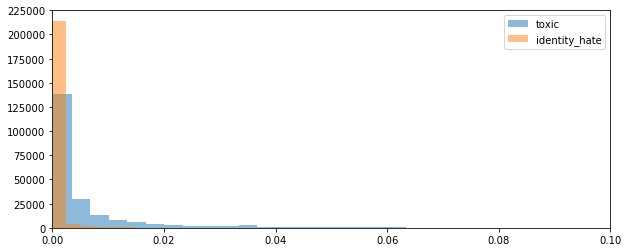

In [253]:
plt.figure(figsize=(10, 4))
n, bins, patches = plt.hist(cnn_kaggle_predict[:,0], 300, normed=0, alpha=0.5,label='toxic')
n, bins, patches = plt.hist(cnn_kaggle_predict[:,5], 100, normed=0, alpha=0.5,label='identity_hate')
plt.legend()
plt.xlim([0,0.1])